# Installing and importing dependencies

In [1]:
!pip install openpyxl
!pip install pandas
!pip install numpy
!pip install rdkit

In [232]:
import pandas as pd
import numpy as np
import time

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit.Chem import Descriptors


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler

from scipy.stats import bootstrap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import History 



import seaborn as sns
import matplotlib.pyplot as plt

ImportError: cannot import name 'bootstrap' from 'scipy.stats' (/home/giustino/.local/lib/python3.8/site-packages/scipy/stats/__init__.py)

In [3]:
#plt.style.use(['science'])
%matplotlib inline
sns.set_theme()
#plt.style.use([])
#plt.style.use(['science','ieee'])

Function that will be used to check that no "na" values appear:

In [4]:
def check_no_na(data):
    if data.isna().sum().eq(0).all():
        print("Success: No NA values found.")
        return
    print("Warning: NA values found.")

Function to build a joint plot:

In [5]:
def plot_joint(y_pred, height=7, name="MODEL"):
    plot = sns.JointGrid(x=y_pred, y=y_test, height=height);
    plot.plot_joint(sns.scatterplot, s=100, color='slateblue')
    plot.plot_marginals(sns.kdeplot, color='slateblue', fill=True)

    x_eq_y=np.arange(np.array(plt.axis()).min(), np.array(plt.axis()).max())

    plot.ax_joint.plot(x_eq_y, x_eq_y, 'k', linewidth = 2, linestyle='--')
    
    plot.ax_joint.set_xlabel("y predicted")
    plot.ax_joint.set_ylabel("y target")
    plot.fig.suptitle(f"target vs predicted Output for the {name} model", y=1.01)
    return plot

# Importing the dataset

In [6]:
df_raw=pd.read_excel("denmark.xlsx")
df_raw.head()

,Catalyst,Imine,Thiol,Output
0,O=P1(O)OC2=C(C3=C(C4CCCCC4)C=C(C5CCCCC5)C=C3C6...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1C,3.134625
1,O=P1(O)OC2=C(C3=CC(C4=C(C)C=C(C)C=C4C)=CC(C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=C(OC)C=C1,1.531803
2,O=P1(O)OC2=C(C3=CC=C(OC)C=C3)C=C4C(C=CC=C4)=C2...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1,1.074991
3,O=P1(O)OC2=[C@]([C@]3=C(Cl)C=C(Cl)C=C3Cl)C=C4C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=CC=C1C,1.334823
4,O=P1(O)OC2=C(C3=C(C=CC4=CC=CC(C=C5)=C46)C6=C5C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1=CC=CC=C1,1.743658


# Looking at the data

### Target values

First of all, it would be important to look at how output values are distributed:

In [7]:
df_raw.describe()

,Output
count,1075.000000
mean,0.987658
std,0.700524
min,-0.419378
25%,0.473820
50%,1.050757
75%,1.370104
max,3.134625


One could also look at the distribution of the target variable:

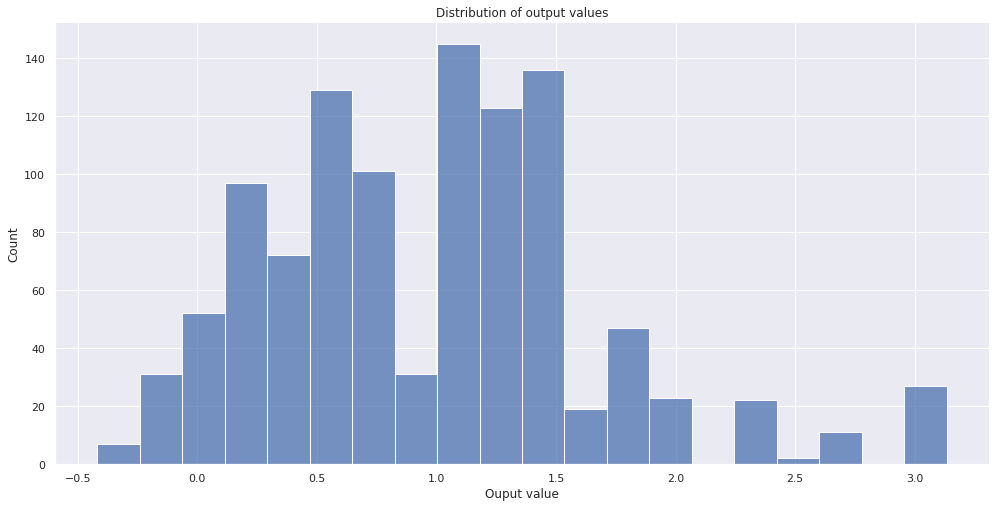

In [8]:
sns.displot(x=df_raw["Output"], bins=20, height=7, aspect=2)
plt.title("Distribution of output values")
plt.xlabel("Ouput value")
plt.show()

The target variable looks to be roughly in the same magnitude and has an approximate gaussian distribution (with a slight tail), which is a good sign as this means that no further transformation is required for it.

### Features

Are there any "na" values?

In [9]:
check_no_na(df_raw)

Success: No NA values found.


How many different molecules are there?

In [10]:
unique_catalysts=df_raw["Catalyst"].unique()
unique_imines=df_raw["Imine"].unique()
unique_thiols=df_raw["Thiol"].unique()
pd.DataFrame({"Unique Catalysts": [unique_catalysts.shape[0]], "Unique Imines": [unique_imines.shape[0]], "Unique Thiols": [unique_thiols.shape[0]]})

,Unique Catalysts,Unique Imines,Unique Thiols
0,43,5,5


Here, one could use One-hot encoding for the Imines and Thiols. This idea was discarded since in the case another Thiol or Imine is added, one would have to retrain the model instead of being able to fine-tune it. 

Show 3 random different Catalysts:

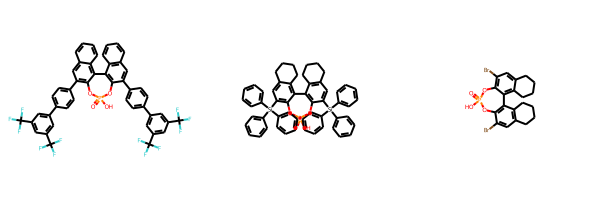

In [11]:
mol_list=[]
unique_molecules=df_raw["Catalyst"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Imine:

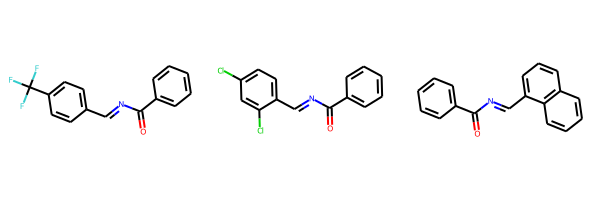

In [12]:
mol_list=[]
unique_molecules=df_raw["Imine"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Thiol:

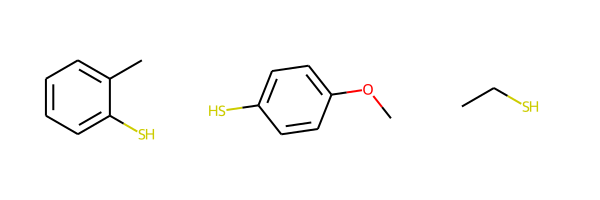

In [13]:
mol_list=[]
unique_molecules=df_raw["Thiol"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules, index)
Draw.MolsToGridImage(mol_list)

# Preprocessing

### Creating RDKit molecules

Translating the "Catalyst", the "Imine" and the "Thiol" columns from SMILES to a RDKit molecule:

In [14]:
df_X=df_raw[["Catalyst", "Imine", "Thiol"]].applymap(Chem.MolFromSmiles)
df_y=df_raw["Output"]
df_X.head()

,Catalyst,Imine,Thiol
0,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8453990>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8453760>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8470350>
1,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8453ad0>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c84537b0>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c84702b0>
2,<rdkit.Chem.rdchem.Mol object at 0x7ff4c84539e0>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8470260>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8485a80>
3,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8453a30>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8470210>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8485a30>
4,<rdkit.Chem.rdchem.Mol object at 0x7ff4c8453a80>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c84701c0>,<rdkit.Chem.rdchem.Mol object at 0x7ff4c84859e0>


Verifying that all the smiles transfered successfuly. The RDKit documentaton states:

>or None on failure:
>
>> ```m = Chem.MolFromMolFile('data/invalid.mol')```
>>
>> ```m is None```
>
>True

So the "na" instances are counted and should be 0 if no problems were encountered:

In [15]:
check_no_na(df_X)

Success: No NA values found.


The train/test ratio was chosen arbitrarily. This could eventually be added as a hyperparameter to find an optimum as has been done [here](https://www.sciencedirect.com/science/article/pii/S2451929420300851). 

In [16]:
X_train, X_test, y_train, y_test=train_test_split(df_X.to_numpy(), df_y.to_numpy(), train_size=0.75)

For later on, Morgan fingerprints will be used. In order to try and search for the best parameters for these molecules, the atom radius and the number of bits used will be searched using grid search with Ridge. The found results will be used in every morgan fingerprints. This is done to avoid finding fingerprints that are too heavy.

In [200]:
model_param_list={}

# Ridge regression

Ridge was chosen instead of linear regression in order to avoid overfitting the model. A linear regression with only the morgan fingerprint parameters to optimize with ```GridSearchCV``` could be considered, removing the need to optimize for morgan fingerprints. Nevertheless, This would be a good addition for the future. One detail that could cause problems is that a bigger fingerprint will be prefered, with only marginally better results but a significantly worse performance.

### Pipeline

Here, in order to later use SKlearn's ```CVGridSearch```, a custom pipeline will be built in order to be able to find the ideal hyperparameters. First step: creating a custom transformer to be used in the pipeline, in order to use RDKit's ```GetMorganFingerprint```'s parameters as hyperparameters for the model.

ridge_search.best_estimator_A similar pipeline template will be used for later trials, using the same functions. Although it is intuitive to assume that the same fingerprint parameters should be used for every model, the ```n_bits``` and the ```n_atom``` hyperparameters should be computed in order to verify that this hypothesis holds for different models.

Personal note: As this is the first time I work with molecules, my first thought was to build a simple ridge regressor and try to give it a morgan fingerprint as input. This is probably not viable since the number of parameters used is too great. Later on, the idea would be to add descriptors into the features, potentially using TF's functional API.

In [21]:
def morgan_fp(X, n_bits, n_atom):
    """Returns numpy array with bits from morgan fingerprint"""
    fp=AllChem.GetMorganFingerprintAsBitVect(X,int(n_atom), nBits=int(n_bits))
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

class fingerprinter(BaseEstimator, TransformerMixin):
    def __init__(self, n_bits=1024, n_atom=2):
        self.n_bits = n_bits # int necessary, otherwise rdkit c++ library doesn't play along
        self.n_atom = n_atom
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        new_X=np.array([])
        for row in X:
            new_row=np.array([])
            for element in row:
                fp=morgan_fp(element, self.n_bits, self.n_atom)
                new_row=np.append(new_row, fp, 0)
            #new_row=new_row.reshape((df_X.shape[1],-1))
            new_X=np.append(new_X, new_row)
            new_X=new_X.reshape([-1, new_row.shape[0]])
        return new_X
#fingerprinter([2,3,4][0], np.linspace(1000, 5000, 10, dtype=int)[0]).transform(X_train)

Now, the first pipeline can be created:

In [22]:
pipe = Pipeline([( "fingerprinter" , fingerprinter()),
                       ("ridge",Ridge())])

Parameter grid, to be fed into the grid search algorithm to find the optimal hyperparameters using cross-validation in order to reduce any biais that could be introduced by the shuffling.

In [23]:
#param_grid={"fingerprinter__n_bits":np.logspace(3, 4, 10, dtype=int), "fingerprinter__n_atom":np.arange(1, 4, 1), "ridge__alpha":np.logspace(0, 2, 4)}
#param_grid={"fingerprinter__n_bits": np.linspace(1000, 5000, 10, dtype=int), "fingerprinter__n_atom":np.array([2, 3, 4]), "ridge__alpha":np.logspace(-3, 1, 5)}
param_grid={"fingerprinter__n_bits": np.linspace(1500, 3000, 10, dtype=int), "fingerprinter__n_atom":np.array([2,3,4]), "ridge__alpha":np.logspace(-3, 3, 10)}
param_grid

{'fingerprinter__n_bits': array([1500, 1666, 1833, 2000, 2166, 2333, 2500, 2666, 2833, 3000]),
 'fingerprinter__n_atom': array([2, 3, 4]),
 'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03])}

The default cross-validation of 5-fold were chosen, as the available computational power is relatively low.

### Fitting

In [24]:
ridge_search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)

ridge_search.fit(X_train, y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(estimator=Pipeline(steps=[('fingerprinter', fingerprinter()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'fingerprinter__n_atom': array([2, 3, 4]),
                         'fingerprinter__n_bits': array([1500, 1666, 1833, 2000, 2166, 2333, 2500, 2666, 2833, 3000]),
                         'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             verbose=3)

In [25]:
print(" Results from Grid Search " )
print("\n The best estimator:\n",ridge_search.best_estimator_)
print("\n The best mean TRAIN score (R^2):\n",ridge_search.cv_results_["mean_test_score"].mean())
print("\n The best STD of TRAIN score (R^2):\n",ridge_search.cv_results_["std_test_score"].mean())
print("\n The TEST MAE of the best estimator:\n",mean_absolute_error(ridge_search.best_estimator_.predict(X_test), y_test))
print("\n The TEST RMSE of the best estimator:\n",mean_squared_error(ridge_search.best_estimator_.predict(X_test), y_test, squared=False))
print("\n The best parameters:\n",ridge_search.best_params_)

 Results from Grid Search 

 The best estimator:
 Pipeline(steps=[('fingerprinter', fingerprinter(n_bits=1666)),
                ('ridge', Ridge(alpha=10.0))])

 The best mean TRAIN score (R^2):
 0.830026049981937

 The best STD of TRAIN score (R^2):
 0.0176555012302152

 The TEST MAE of the best estimator:
 0.1789242338008838

 The TEST RMSE of the best estimator:
 0.24974190067833374

 The best parameters:
 {'fingerprinter__n_atom': 2, 'fingerprinter__n_bits': 1666, 'ridge__alpha': 10.0}


In [26]:
ridge_search.best_params_

{'fingerprinter__n_atom': 2,
 'fingerprinter__n_bits': 1666,
 'ridge__alpha': 10.0}

Looking at the relative distributions of the predicted output vs the target output: 

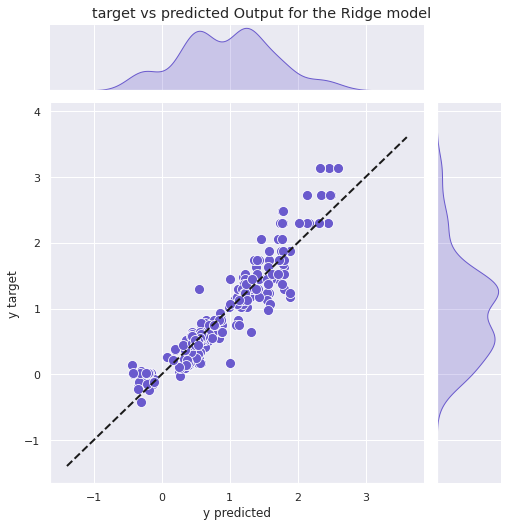

In [233]:
plot_joint(ridge_search.best_estimator_.predict(X_test), name="Ridge");

In [202]:
model_param_list["ridge_simple"]={"alpha":ridge_search.best_params_["ridge__alpha"]}

In order to streamline the process, the fingerprint with the parameters as found above before will be used:

In [28]:
f=lambda x: fingerprinter(n_bits=ridge_search.best_params_["fingerprinter__n_bits"], n_atom=ridge_search.best_params_["fingerprinter__n_atom"]).transform(x)
X_train_fp, X_test_fp=f(X_train), f(X_test)

In [29]:
X_test_fp.shape

(269, 4998)

# Random Forest Regression

Same as before, this time with a random forest regressor. Because of the limited computational power, only the n_estimators will be considered along with XXXXXXX, the morgan fingerprints marameters will not be changed as it is suspected that they would probably only get bigger as stated before. The fingerprint parameters are optimized again because of the fear that the ridge regressor punished bigger fingerprints (more added weights, even small, can be punished. Note the big alpha parameter):

### Pipeline

In [30]:
pipe = Pipeline([("forest",RandomForestRegressor())])

The number of tested parameters have been significantly reduced (Lack of computational power)

In [31]:
param_grid={"forest__max_depth": np.linspace(50, 1500, 15,  dtype=int)}
param_grid

{'forest__max_depth': array([  50,  153,  257,  360,  464,  567,  671,  775,  878,  982, 1085,
        1189, 1292, 1396, 1500])}

### Fitting

In [32]:
forest_search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)

forest_search.fit(X_train_fp, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=Pipeline(steps=[('forest', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'forest__max_depth': array([  50,  153,  257,  360,  464,  567,  671,  775,  878,  982, 1085,
       1189, 1292, 1396, 1500])},
             verbose=3)

In [33]:
print(" Results from Grid Search " )
print("\n The best estimator:\n",forest_search.best_estimator_)
print("\n The best mean TRAIN score (R^2):\n",forest_search.cv_results_["mean_test_score"].mean())
print("\n The best STD of TRAIN score (R^2):\n",forest_search.cv_results_["std_test_score"].mean())
print("\n The TEST MAE of the best estimator:\n",mean_absolute_error(forest_search.best_estimator_.predict(X_test_fp), y_test))
print("\n The TEST RMSE of the best estimator:\n",mean_squared_error(forest_search.best_estimator_.predict(X_test_fp), y_test, squared=False))
print("\n The best parameters:\n",forest_search.best_params_)

 Results from Grid Search 

 The best estimator:
 Pipeline(steps=[('forest', RandomForestRegressor(max_depth=775))])

 The best mean TRAIN score (R^2):
 0.8997325449863905

 The best STD of TRAIN score (R^2):
 0.027766752906612128

 The TEST MAE of the best estimator:
 0.14072125856018586

 The TEST RMSE of the best estimator:
 0.2077852420997711

 The best parameters:
 {'forest__max_depth': 775}


In [34]:
forest_search.best_params_

{'forest__max_depth': 775}

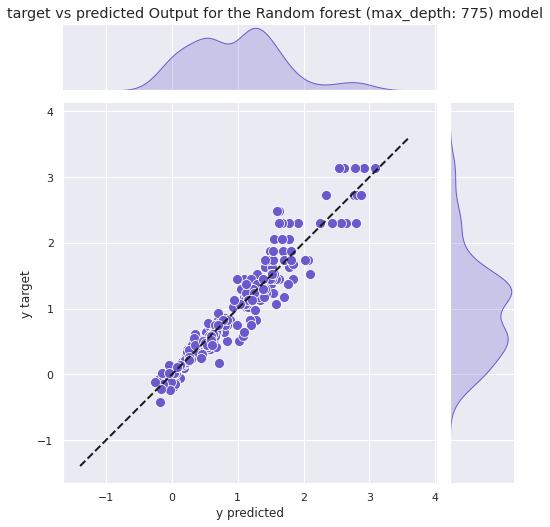

In [35]:
plot_joint(forest_search.best_estimator_.predict(X_test_fp), name=f"Random forest (max_depth: {forest_search.best_params_['forest__max_depth']})");

In [205]:
model_param_list["forest_simple"]={"max_depth":forest_search.best_params_["forest__max_depth"]}

# Neural network

### Pipeline

Here, the number of layers  will be fixed and the focus will be on the dropout rate and the number of perceptrons per layer. This was done because of the limited computational power and the architecture of the model should definitively be studied in more details:

In [140]:
def create_model(lenX, optimizer='Adam',
                 dropout=0.2, n_perceptrons=64, summary=True):
    inputs = keras.Input(shape=(lenX,))
    
    dense = layers.Dense(n_perceptrons, activation="relu")
    x1 = dense(inputs)
    
    dropout1 = Dropout(dropout)(x1)
    
    dense = layers.Dense(n_perceptrons/2, activation="relu")
    x2 = dense(dropout1)
    
    dropout2 = Dropout(dropout)(x2)
    
    dense = layers.Dense(1)
    outputs = dense(dropout2)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="simple_MLP")
    if summary:
        model.summary()
    
    model.compile(loss=keras.losses.MSE,optimizer=optimizer)

    return model

In order to use the same methodology as before, the cross validation has to be done manually. A monitor has been added to stop if the model is not learning anymore, to avoid overfitting. There is another validation split in the TF model to help stopping early if the improvement in each epoch is too small:

In [149]:
def CV_NN(X, n_split=5, dropout=0.2, n_perceptrons=64):
    """cross validation for grid search with NN"""
    CV_RMSE=np.array([])
    
    for train_index,test_index in KFold(n_split).split(X):
        monitor = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3, patience=2)
        
        X_train_split,X_test_split=X[train_index],X[test_index]
        y_train_split,y_test_split=y_train[train_index],y_train[test_index]

        model=create_model(lenX=len(X[0]), summary=False, dropout=dropout, n_perceptrons=n_perceptrons)
        model.fit(X_train_split.reshape([-1, X.shape[1]]), y_train_split, callbacks =[monitor], epochs=100, validation_split=0.25, verbose=0)

        CV_RMSE=np.append(CV_RMSE, mean_squared_error(model.predict(X_test_split),y_test_split, squared=False))
    return CV_RMSE

### Fitting, Hyperparameters optimization

The parameters should be independent of each other, which is why they can be found independently:

In [145]:
dropout_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
n_perceptrons_list=[32, 64, 128, 256, 512]

best_loss=10e10
for dropout in dropout_list:
    loss=CV_NN(X_train_fp, dropout=dropout).mean()
    if loss<best_loss:
        best_loss=loss
        best_dropout=dropout

best_loss=10e10
for n_perceptrons in n_perceptrons_list:
    loss=CV_NN(X_train_fp, n_perceptrons=n_perceptrons).mean()
    if loss<best_loss:
        best_loss=loss
        best_n_perceptrons=n_perceptrons


In [150]:
best_dropout,best_n_perceptrons

(0, 256)

A model can now be built with the best parameters found above:

In [161]:
model_simple_NN=create_model(lenX=len(X_train_fp[0]),summary=True, dropout=best_dropout, n_perceptrons=best_n_perceptrons)
monitor = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3, patience=2)
model_simple_NN.fit(X_train_fp.reshape([-1, ridge_search.best_params_["fingerprinter__n_bits"]*3]), y_train, callbacks =[monitor], epochs=100, validation_split=0.25)

Model: "simple_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_436 (InputLayer)       [(None, 4998)]            0         
_________________________________________________________________
dense_1305 (Dense)           (None, 256)               1279744   
_________________________________________________________________
dropout_870 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_1306 (Dense)           (None, 128)               32896     
_________________________________________________________________
dropout_871 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1307 (Dense)           (None, 1)                 129       
Total params: 1,312,769
Trainable params: 1,312,769
Non-trainable params: 0
______________________________________________

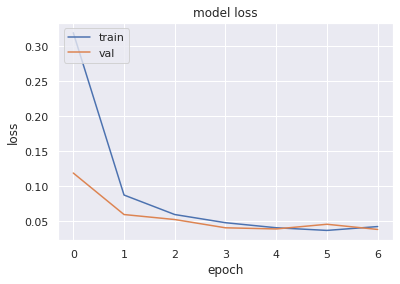

In [162]:
plt.plot(model_simple_NN.history.history['loss'])
plt.plot(model_simple_NN.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
mean_squared_error(model_simple_NN.predict(X_test_fp),y_test, squared=False)

0.22499481736944985

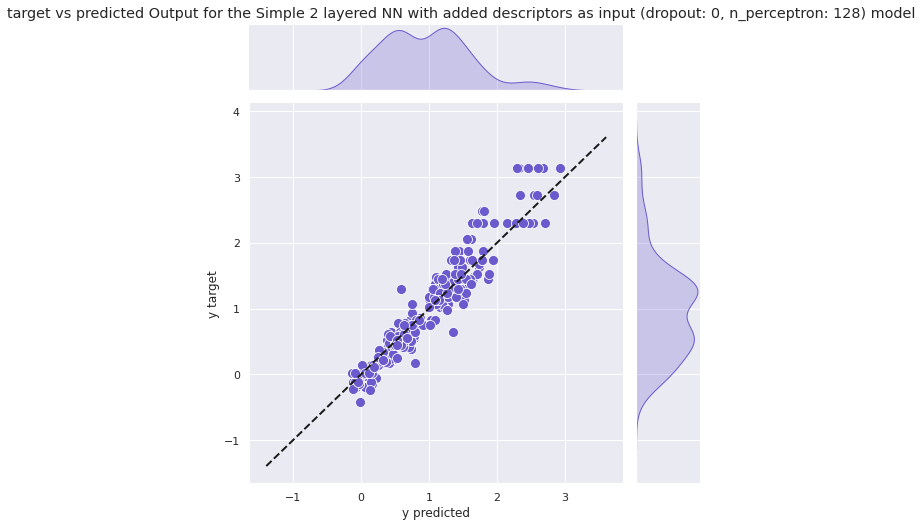

In [181]:
plot_joint(model_simple_NN.predict(X_test_fp).reshape((-1,)), name=f"Simple 2 layered NN with added descriptors as input (dropout: {best_dropout}, n_perceptron: {best_n_perceptrons})");

In [207]:
model_param_list["NN_simple"]={"n_perceptrons":best_n_perceptrons, "dropout": best_dropout}

# Descriptors

By slightly modifying the function built before, it is possible to add descriptors to the features. The ```FractionCSP3```, ```NOCount```, ```MolLogP```, ```TPSA``` (topological polar surface area), ```NHOHCount```, ```NumRotatableBonds```,```NumHDonors```,```NumAromaticRings```, ```NumHAcceptors```, ```NumHeteroatoms```, ```NumValenceElectrons```. The choice of the descriptors was not done methodically and should be examined in more details later on:

In [94]:
class fingerprinterDescr(BaseEstimator, TransformerMixin):
    def __init__(self, n_bits=1024, n_atom=2):
        self.n_bits = n_bits # int necessary, otherwise rdkit c++ library doesn't play along
        self.n_atom = n_atom
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_X=np.array([])
        
        for row in X:
            new_row=np.array([])
            
            for element in row:
                descriptor_list=[Descriptors.FractionCSP3(element), Descriptors.NOCount(element), Descriptors.MolLogP(element), Descriptors.NumRotatableBonds(element), Descriptors.TPSA(element), Descriptors.NumHDonors(element), Descriptors.NHOHCount(element), Descriptors.NumAromaticRings(element), Descriptors.NumHeteroatoms(element), Descriptors.NumValenceElectrons(element)]
                fp=np.append(morgan_fp(element, self.n_bits, self.n_atom), descriptor_list)
                new_row=np.append(new_row, fp, 0)

            new_X=np.append(new_X, new_row)
            new_X=new_X.reshape([-1, new_row.shape[0]])
        return new_X

In [95]:
f=lambda x: fingerprinterDescr(n_bits=ridge_search.best_params_["fingerprinter__n_bits"], n_atom=ridge_search.best_params_["fingerprinter__n_atom"]).transform(x)
X_train_descr, X_test_descr=f(X_train), f(X_test)

In [96]:
Descriptors.TPSA(X_train[0][1])

29.43

In [97]:
X_train_descr.shape

(806, 5028)

The features are not composed of only 1 and 0 anymore, therefore a scaler is needed:

In [98]:
scaler=StandardScaler()
X_train_descr=scaler.fit_transform(X_train_descr)
X_test_descr=scaler.transform(X_test_descr)

## Ridge

As the features are already built, there is no need of building the fingerprints again. Ridge Alpha is optimized again.

In [99]:
pipe = Pipeline([("ridge",Ridge())])

Parameter grid, to be fed into the grid search algorithm to find the optimal hyperparameters using cross-validation in order to reduce any biais that could be introduced by the shuffling.

In [100]:
param_grid={"ridge__alpha":np.logspace(-3, 3, 10)}
param_grid

{'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03])}

In [101]:
ridge_search_descr = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)

ridge_search_descr.fit(X_train_descr, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(estimator=Pipeline(steps=[('ridge', Ridge())]), n_jobs=-1,
             param_grid={'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             verbose=3)

In [102]:
print(" Results from Grid Search " )
print("\n The best estimator:\n",ridge_search_descr.best_estimator_)
print("\n The best mean TRAIN score (R^2):\n",ridge_search_descr.cv_results_["mean_test_score"].mean())
print("\n The best STD of TRAIN score (R^2):\n",ridge_search_descr.cv_results_["std_test_score"].mean())
print("\n The TEST MAE of the best estimator:\n",mean_absolute_error(ridge_search_descr.best_estimator_.predict(X_test_descr), y_test))
print("\n The TEST RMSE of the best estimator:\n",mean_squared_error(ridge_search_descr.best_estimator_.predict(X_test_descr), y_test, squared=False))
print("\n The best parameters:\n",ridge_search_descr.best_params_)

 Results from Grid Search 

 The best estimator:
 Pipeline(steps=[('ridge', Ridge(alpha=215.44346900318823))])

 The best mean TRAIN score (R^2):
 0.8571116386828754

 The best STD of TRAIN score (R^2):
 0.01837378775417344

 The TEST MAE of the best estimator:
 0.17848309963233874

 The TEST RMSE of the best estimator:
 0.25013553264718646

 The best parameters:
 {'ridge__alpha': 215.44346900318823}


In [103]:
ridge_search_descr.best_params_

{'ridge__alpha': 215.44346900318823}

Looking at the relative distributions of the predicted output vs the target output: 

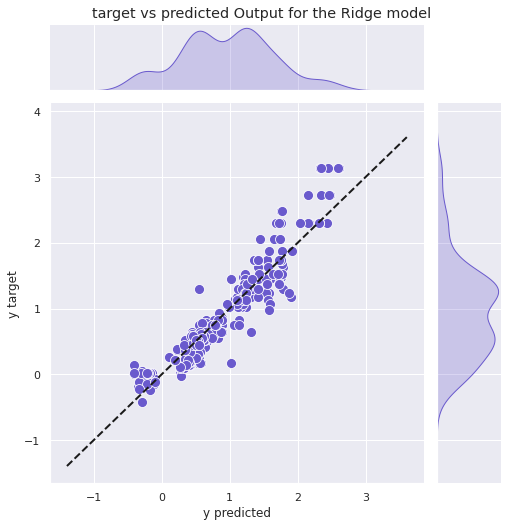

In [104]:
plot_joint(ridge_search_descr.best_estimator_.predict(X_test_descr), name="Ridge");

In [209]:
model_param_list["ridge_descriptor"]={"alpha":ridge_search.best_params_["ridge__alpha"]}

In [210]:
model_param_list

{'ridge_simple': {'alpha': 10.0},
 'forest_simple': {'max_depth': 775},
 'NN_simple': {'n_perceptrons': 128, 'dropout': 0},
 'ridge_descriptor': {'alpha': 10.0}}

## Random Forest

As the features are already built, there is no need of building the fingerprints again. Ridge Alpha is optimized again.

In [105]:
pipe = Pipeline([("forest",RandomForestRegressor())])

Parameter grid, to be fed into the grid search algorithm to find the optimal hyperparameters using cross-validation in order to reduce any biais that could be introduced by the shuffling.

In [106]:
param_grid={"forest__max_depth": np.linspace(50, 1500, 15,  dtype=int)}
param_grid

{'forest__max_depth': array([  50,  153,  257,  360,  464,  567,  671,  775,  878,  982, 1085,
        1189, 1292, 1396, 1500])}

In [107]:
forest_search_descr = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)

forest_search_descr.fit(X_train_descr, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=Pipeline(steps=[('forest', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'forest__max_depth': array([  50,  153,  257,  360,  464,  567,  671,  775,  878,  982, 1085,
       1189, 1292, 1396, 1500])},
             verbose=3)

In [108]:
print(" Results from Grid Search " )
print("\n The best estimator:\n",forest_search_descr.best_estimator_)
print("\n The best mean TRAIN score (R^2):\n",forest_search_descr.cv_results_["mean_test_score"].mean())
print("\n The best STD of TRAIN score (R^2):\n",forest_search_descr.cv_results_["std_test_score"].mean())
print("\n The TEST MAE of the best estimator:\n",mean_absolute_error(forest_search_descr.best_estimator_.predict(X_test_descr), y_test))
print("\n The TEST RMSE of the best estimator:\n",mean_squared_error(forest_search_descr.best_estimator_.predict(X_test_descr), y_test, squared=False))
print("\n The best parameters:\n",forest_search_descr.best_params_)

 Results from Grid Search 

 The best estimator:
 Pipeline(steps=[('forest', RandomForestRegressor(max_depth=1292))])

 The best mean TRAIN score (R^2):
 0.9025689194777271

 The best STD of TRAIN score (R^2):
 0.02884506748470034

 The TEST MAE of the best estimator:
 0.14117619773449813

 The TEST RMSE of the best estimator:
 0.2083041530618917

 The best parameters:
 {'forest__max_depth': 1292}


In [109]:
forest_search_descr.best_params_

{'forest__max_depth': 1292}

Looking at the relative distributions of the predicted output vs the target output: 

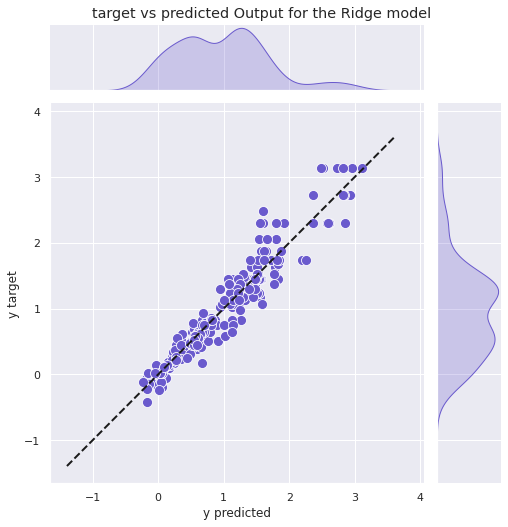

In [110]:
plot_joint(forest_search_descr.best_estimator_.predict(X_test_descr), name="Ridge");

In [211]:
model_param_list["forest_descriptor"]={"max_depth":forest_search.best_params_["forest__max_depth"]}

## Neural network

The parameters should be independent of each other, which is why they can be found independently:

In [167]:
dropout_list=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
n_perceptrons_list=[32, 64, 128, 256, 512]

best_loss=10e10
for dropout in dropout_list:
    loss=CV_NN(X_train_descr, dropout=dropout).mean()
    if loss<best_loss:
        best_loss=loss
        best_dropout=dropout

best_loss=10e10
for n_perceptrons in n_perceptrons_list:
    loss=CV_NN(X_train_descr, n_perceptrons=n_perceptrons).mean()
    if loss<best_loss:
        best_loss=loss
        best_n_perceptrons=n_perceptrons


In [168]:
best_dropout,best_n_perceptrons

(0, 128)

A model can now be built with the best parameters found above:

In [177]:
model_simple_NN_descr=create_model(lenX=len(X_train_descr[0]),summary=True, dropout=best_dropout, n_perceptrons=best_n_perceptrons)
monitor = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3, patience=2)
model_simple_NN_descr.fit(X_train_descr.reshape([-1, X_train_descr.shape[1]]), y_train, callbacks =[monitor], epochs=100, validation_split=0.25)

Model: "simple_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_515 (InputLayer)       [(None, 5028)]            0         
_________________________________________________________________
dense_1542 (Dense)           (None, 128)               643712    
_________________________________________________________________
dropout_1028 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1543 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1029 (Dropout)       (None, 64)                0         
_________________________________________________________________
dense_1544 (Dense)           (None, 1)                 65        
Total params: 652,033
Trainable params: 652,033
Non-trainable params: 0
__________________________________________________

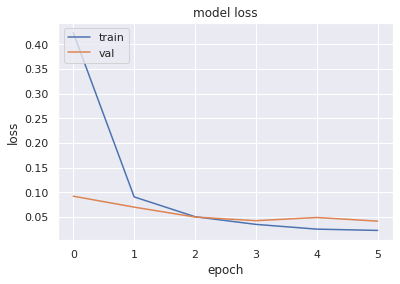

In [178]:
plt.plot(model_simple_NN_descr.history.history['loss'])
plt.plot(model_simple_NN_descr.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [179]:
mean_squared_error(model_simple_NN_descr.predict(X_test_descr),y_test, squared=False)

0.2388860792878877

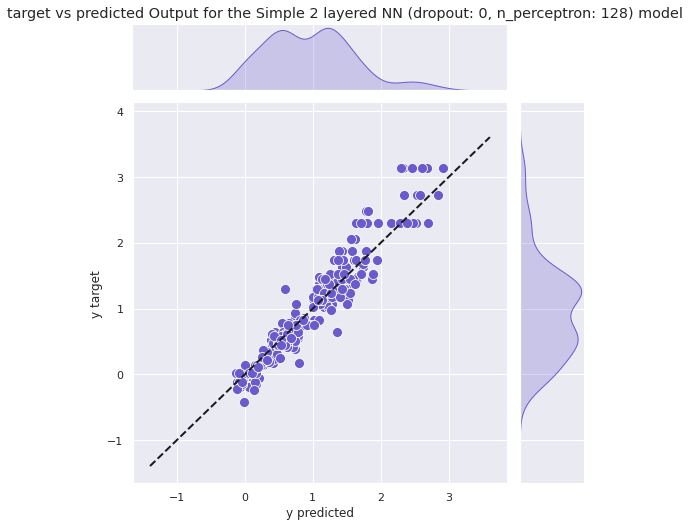

In [180]:
plot_joint(model_simple_NN.predict(X_test_fp).reshape((-1,)), name=f"Simple 2 layered NN (dropout: {best_dropout}, n_perceptron: {best_n_perceptrons})");

In [213]:
model_param_list["NN_descriptor"]={"n_perceptrons":best_n_perceptrons, "dropout": best_dropout}

# Model evaluation

Cross-validation with bootstrapping was chosen to compare the models. 

First, a look at the extracted parameters. The hyperparameters seem to be close to the same for both with and without the added descriptors. 

In [216]:
model_param_list

{'ridge_simple': {'alpha': 10.0},
 'forest_simple': {'max_depth': 775},
 'NN_simple': {'n_perceptrons': 128, 'dropout': 0},
 'ridge_descriptor': {'alpha': 10.0},
 'forest_descriptor': {'max_depth': 775},
 'NN_descriptor': {'n_perceptrons': 128, 'dropout': 0}}

Building a class that can fit all the models. This class will be reinitialized every time to make sure the models are always trained from 0

In [242]:
class FitModels():
    def ridge_simple(self):
        model = Ridge(alpha=model_param_list["ridge_simple"]["alpha"])
        model.fit(X_train_fp, y_train)
        return model
    def ridge_descriptor(self):
        model = Ridge(alpha=model_param_list["ridge_simple"]["alpha"])
        model.fit(X_train_descr, y_train)
        return model
    def forest_simple(self):
        model = RandomForestRegressor(max_depth=model_param_list["forest_simple"]["max_depth"])
        model.fit(X_train_fp, y_train)
        return model
    def forest_descriptor(self):
        model = RandomForestRegressor(max_depth=model_param_list["forest_descriptor"]["max_depth"])
        model.fit(X_train_descr, y_train)
        return model
    def NN_simple(self):
        model_simple_NN=create_model(lenX=len(X_train_fp[0]),summary=True, dropout=model_param_list["NN_simple"]["dropout"], n_perceptrons=model_param_list["NN_simple"]["n_perceptrons"])
        monitor = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3, patience=2)
        model_simple_NN.fit(X_train_fp.reshape([-1, X_train_fp.shape[1]]), y_train, callbacks =[monitor], epochs=100, validation_split=0.2)
        return model_simple_NN
    def NN_descriptor(self):
        model_simple_NN_descr=create_model(lenX=len(X_train_descr[0]),summary=True, dropout=model_param_list["NN_descriptor"]["dropout"], n_perceptrons=model_param_list["NN_descriptor"]["n_perceptrons"])
        monitor = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3, patience=2)
        model_simple_NN_descr.fit(X_train_descr.reshape([-1, X_train_descr.shape[1]]), y_train, callbacks =[monitor], epochs=100, validation_split=0.2)
        return model_simple_NN_descr

In [243]:
fitter=FitModels()
MSE_ridge_simple=fitter.ridge_simple()
MSE_ridge_simple=fitter.ridge_descriptor()
MSE_ridge_simple=fitter.forest_simple()
MSE_ridge_simple=fitter.forest_descriptor()
MSE_ridge_simple=fitter.NN_simple()
MSE_ridge_simple=fitter.NN_descriptor()

Model: "simple_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_517 (InputLayer)       [(None, 4998)]            0         
_________________________________________________________________
dense_1548 (Dense)           (None, 128)               639872    
_________________________________________________________________
dropout_1032 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1549 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1033 (Dropout)       (None, 64)                0         
_________________________________________________________________
dense_1550 (Dense)           (None, 1)                 65        
Total params: 648,193
Trainable params: 648,193
Non-trainable params: 0
__________________________________________________

Personal notes: Iterations:
1. Tried to compute morgan fingerprint and take that output to compute a ridge regression. This would have been the simplest and most naive iteration. Initially a failure, I ended up being able to fine tune it more or less. Due to the high cost of the computations I did not fine-tune the hyperparameters too much.
2. Random forest regression. I realized here that the morgan fingerprint parameters would be optimizable from a simple linear regression and could then be discarded as a hyperparameter. If time allows it, This will get changed, but I would like to continue building some models and a good way of comparing them before. 
3. Simple 2 layer NN. Here I concentrate on the layer parameters as hyperparameters. 
4. Descriptors: every of the models used before but with descriptors
5. Bootstrapping: to test robustness and compare performance of each model.

For the bootstrapping: sample size has to be extremely small, otherwise it does the take too much time (>7h...). Is pretty useless like this. In case of trying again: https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.cross_validation.Bootstrap.html

Alternative: use qsar fingerprints: http://www.qsar4u.com/files/qsar_rdkit_tutorial/qsar-rdkit.html

Alternative to consider: https://pubs.acs.org/doi/10.1021/acs.jcim.7b00616

Why the morgan fingerprint? The litterature does not seem to agree but they seem to lean towards that fingerprint: http://practicalcheminformatics.blogspot.com/2020/03/benchmarking-one-molecular-fingerprint.html